<a href="https://colab.research.google.com/github/mvadrev/coviScan/blob/main/A_novel_scoring_function_for_LIME_based_activation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
!pip install lime
!pip install timm https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
!pip install pydub
!pip install pedalboard


     \ 297 kB 3.8 MB/s
     |████████████████████████████████| 431 kB 9.8 MB/s 
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3838 sha256=09efb807637186b3688dc41dd43fba3d9e69c13822974cdfc9605d2611129293
  Stored in directory: /tmp/pip-ephem-wheel-cache-98bolap1/wheels/52/7b/7d/ce0e0ddbb7864877a0e31a96f883a928791ebfa6eaf7b52f87
Successfully built torchsampler
     |████████████████████████████████| 275 kB 9.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d7a414c1e9e92e6a1713b0b137a31e8862e5cf5ad09f6eb9689333dfd09fc6fe
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
  Using cached https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
     |████████████████████████████████| 5.0 MB 7.7 MB/s 


In [2]:
import os 
import shutil
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from collections import Counter
import math

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import tqdm.notebook as tqdm
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.nn import functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn import decomposition
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import timm 
import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [4]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: content/data3/
   creating: content/data3/positive/
 extracting: content/data3/positive/0drfnqVwccT6UmgVLQEuyVglDC23_cough-heavy.wav.png  
 extracting: content/data3/positive/UoUR3jonNScKDHaH8HVDKAEeTpj2_cough-heavy.wav.png  
 extracting: content/data3/positive/kAnUnZf9b6d4bkjJCawv0nCGJUI2_cough-heavy.wav.png  
 extracting: content/data3/positive/ZaTgRbDWn9d1MMPanam0NCupVCl1_cough-heavy.wav.png  
 extracting: content/data3/positive/373AihVhKDYxeUR24zNi11JavqC3_cough-shallow.wav.png  
 extracting: content/data3/positive/ffXE7VADnca3RAVTmQd60PrIRfk2_cough-heavy.wav.png  
 extracting: content/data3/positive/iowFPDECVScrXnuQUdAzFR5lZTn2_cough-shallow.wav.png  
 extracting: content/data3/positive/8Oot6FsWpdgyMs1eXi5PeTlHkO22_cough-heavy.wav.png  
 extracting: content/data3/positive/FLNZB0Us1PgOdXLJUC4tmsvRrH43_cough-heavy.wav.png  
 extracting: content/data3/positive/1C6BCvPkrjT62P0843qRIsRPClF2_cough-heavy.wav.png  
 extracting: content/data3/positi

In [8]:
# Set randonm seed for resproducibility
random.seed(1234)
np.random.seed(1234)
data_dir = "/content/data3"
images_dir = os.path.join(data_dir, 'images')
image_files = glob.glob(images_dir+'/*/*')
labels = []
for file_name in image_files:
  labels.append(file_name.split("/")[4])
img_df = pd.DataFrame({'images':image_files, 'labels':labels})
img_df.head()


,images,labels
0,/content/data3/images/positive/0drfnqVwccT6Umg...,positive
1,/content/data3/images/positive/UoUR3jonNScKDHa...,positive
2,/content/data3/images/positive/kAnUnZf9b6d4bkj...,positive
3,/content/data3/images/positive/ZaTgRbDWn9d1MMP...,positive
4,/content/data3/images/positive/373AihVhKDYxeUR...,positive


In [9]:
# Split dataset into train , test and validation
train, test = train_test_split(img_df, stratify=img_df.labels, test_size=0.1, random_state=42)
train, valid = train_test_split(train, stratify=train.labels, test_size=0.1, random_state=42)

In [10]:
#creating train, test and validation directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(val_dir)

classes = os.listdir(images_dir)
print("There are",classes,"in the data")

for c in classes:   
    train_filter = train[train.labels==c]
    test_filter = test[test.labels==c]
    val_filter = valid[valid.labels==c]

    train_filter_images = train_filter.images.tolist()
    test_filter_images = test_filter.images.tolist()
    val_filter_images = val_filter.images.tolist()

    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    os.makedirs(os.path.join(val_dir, c), exist_ok = True)

    for image in train_filter_images:

        image_name = image.split("/")[5]
        image_dst = os.path.join(train_dir, c, image_name) 
        shutil.copyfile(image, image_dst)
        
    for image in test_filter_images:
        image_name = image.split("/")[5]
        image_dst = os.path.join(test_dir, c, image_name) 
        shutil.copyfile(image, image_dst)

    for image in val_filter_images:
        image_name = image.split("/")[5]
        image_dst = os.path.join(val_dir, c, image_name) 
        shutil.copyfile(image, image_dst)

There are ['positive', 'healthy'] in the data


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


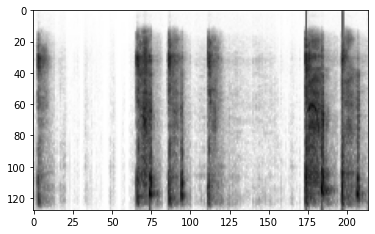

In [13]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('/content/data3/test/positive/0kFnp420ZNR1jLp0JWCjMGDzvXo2_cough-heavy.wav.png')
plt.imshow(img)

In [14]:
class CFG:

  epochs =25                          
  lr = 0.001                           
  batch_size = 16                      
  img_size = 224                       

  # going to be used for loading dataset
  train_path='/content/data3/train'
  validate_path='/content/data3/val'
  test_path='/content/data3/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [15]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(size=(CFG.img_size,CFG.img_size))
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [17]:

# Load effNet saved model
model_name = 'efficientnetv2_rw_m'
import tqdm.notebook as tqdm

efficientnetv2_model = timm.create_model(model_name,pretrained=True) #load pretrained model
# Freeze model parameters
for param in efficientnetv2_model.parameters():
  param.requires_grad = False

# Change the final layer of Efficientnetv2 Model for Transfer Learning
#we are updating it as a 2-class classifier:
efficientnetv2_model.classifier = nn.Sequential(
    nn.Linear(in_features=2152, out_features=625), #2152 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

# as we are training on GPU. Convert model to be used on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetv2_model.to(device) # move the model to GPU
efficientnetv2_model.load_state_dict(torch.load('/content/effnet.pt'))
efficientnetv2_model.eval()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnetv2_rw_m_agc-3d90cb1e.pth" to /root/.cache/torch/hub/checkpoints/efficientnetv2_rw_m_agc-3d90cb1e.pth


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): Identity()
        (conv_pwl): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): I

In [18]:
def batch_predict(images):
    efficientnetv2_model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    efficientnetv2_model.to(device)
    batch = batch.to(device)
    
    logits = efficientnetv2_model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [19]:
#test on a single image
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

1

In [31]:
test_pred

array([[0.2577908, 0.7422092]], dtype=float32)

In [20]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

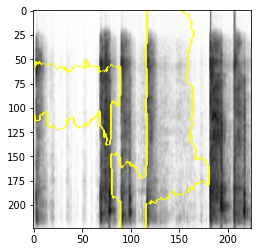

In [21]:
#Let's use mask on image and see the areas that are encouraging the top prediction.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [73]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


In [164]:
# This function takes in_dir, out_dir
# saves all masks in masks
# saves all masks in originals
from matplotlib import cm

def lime_gen(in_dir, out_dir, status):
  filesList_healthy = os.listdir(in_dir + '/healthy')
  filesList_positive = os.listdir(in_dir + '/positive')



  if(status == True):
    print("User selected: process positive")
    try:
      for i in tqdm.tqdm(range(len(filesList_positive ))):
        current_file = in_dir + '/positive/' + filesList_positive[i]
        im = Image.open(current_file) 

        print("**processing...", current_file)
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(np.array(pill_transf(im)), 
                                          batch_predict, 
                                          top_labels=2, 
                                          hide_color=0, 
                                          num_samples=1000) 
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
        img_boundry1 = mark_boundaries(temp/255.0, mask)
        print(type(img_boundry1))
        im = Image.fromarray(np.uint8(img_boundry1)).convert('RGB')
        plt.imsave(out_dir + '/masks/' + 'positive/' + filesList_positive[i], img_boundry1)
        original =  Image.open(current_file)
        print("Saving original", out_dir + '/orignals/' + 'positive/' + filesList_positive[i])
    
        original.save(out_dir + '/originals/' + 'positive/' + filesList_positive[i])

    except: 
      pass    
  else:

    try:
      for i in tqdm.tqdm(range(len(filesList_healthy ))):
        current_file_h = in_dir + '/healthy/' + filesList_healthy[i]
        im = Image.open(current_file_h) 

        print("**processing...", current_file_h)
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(np.array(pill_transf(im)), 
                                          batch_predict, 
                                          top_labels=2, 
                                          hide_color=0, 
                                          num_samples=1000) 
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
        img_boundry1 = mark_boundaries(temp/255.0, mask)
        print(type(img_boundry1))
        im = Image.fromarray(np.uint8(img_boundry1)).convert('RGB')
        plt.imsave(out_dir + '/masks/' + 'healthy/' + filesList_healthy[i], img_boundry1)
        original =  Image.open(current_file_h)
        print("Saving original", out_dir + '/orignals/' + 'healthy/' + filesList_healthy[i])
        original.save(out_dir + '/originals/' + 'healthy/' + filesList_healthy[i])

    except:
      pass  





In [165]:
#Generate LIME originals and masks for positive class only
lime_gen('/content/data3/test','/content/explainer', status=True)

User selected: process positive


  0%|          | 0/137 [00:00<?, ?it/s]

**processing... /content/data3/test/positive/kAnUnZf9b6d4bkjJCawv0nCGJUI2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/kAnUnZf9b6d4bkjJCawv0nCGJUI2_cough-heavy.wav.png
**processing... /content/data3/test/positive/iowFPDECVScrXnuQUdAzFR5lZTn2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/iowFPDECVScrXnuQUdAzFR5lZTn2_cough-shallow.wav.png
**processing... /content/data3/test/positive/WscnqzOzFwUvHbl7MKfRcioUI9t1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/WscnqzOzFwUvHbl7MKfRcioUI9t1_cough-shallow.wav.png
**processing... /content/data3/test/positive/IimA0GnOm7ZR4nEr8k0kG4eaR7A3_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/IimA0GnOm7ZR4nEr8k0kG4eaR7A3_cough-shallow.wav.png
**processing... /content/data3/test/positive/Ued1DKV2NkUnzWjJcPMxA6Q261r1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/Ued1DKV2NkUnzWjJcPMxA6Q261r1_cough-heavy.wav.png
**processing... /content/data3/test/positive/xVC8kMuWNme6VSFOvNVT0j21Qw12_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/xVC8kMuWNme6VSFOvNVT0j21Qw12_cough-shallow.wav.png
**processing... /content/data3/test/positive/gxbBHDQWiSWdAnKyqT0BMuH9T2k1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/gxbBHDQWiSWdAnKyqT0BMuH9T2k1_cough-shallow.wav.png
**processing... /content/data3/test/positive/oq0WLx6gAuM9yYU3fybYvV4OqLf1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/oq0WLx6gAuM9yYU3fybYvV4OqLf1_cough-shallow.wav.png
**processing... /content/data3/test/positive/BG1rEPoPYKUAHCYVzPrcB3I6VUn2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/BG1rEPoPYKUAHCYVzPrcB3I6VUn2_cough-shallow.wav.png
**processing... /content/data3/test/positive/M9CdGPOCUFPWV7KnLgvStPgjLrF3_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/M9CdGPOCUFPWV7KnLgvStPgjLrF3_cough-shallow.wav.png
**processing... /content/data3/test/positive/xgdd8l7OfrMOkvrskW5s6fxk3mg2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/xgdd8l7OfrMOkvrskW5s6fxk3mg2_cough-heavy.wav.png
**processing... /content/data3/test/positive/BtooK4c5GOf6ic0GB9lAUXQEaaO2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/BtooK4c5GOf6ic0GB9lAUXQEaaO2_cough-shallow.wav.png
**processing... /content/data3/test/positive/bPkWc2GJQNc3PRSt1CWI3ulXpvC2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/bPkWc2GJQNc3PRSt1CWI3ulXpvC2_cough-heavy.wav.png
**processing... /content/data3/test/positive/FYcPCfSynRbFpXtFI49Vb4JcEJP2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/FYcPCfSynRbFpXtFI49Vb4JcEJP2_cough-shallow.wav.png
**processing... /content/data3/test/positive/h5e7Ff7hWON2RPULdDCxad7xpGv2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/h5e7Ff7hWON2RPULdDCxad7xpGv2_cough-heavy.wav.png
**processing... /content/data3/test/positive/CHWPcgqcWBX6gcrIf8Dqn9mybfQ2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/CHWPcgqcWBX6gcrIf8Dqn9mybfQ2_cough-heavy.wav.png
**processing... /content/data3/test/positive/Vs8uBCHBz3eNp8HeOdbnDoG4RJT2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/Vs8uBCHBz3eNp8HeOdbnDoG4RJT2_cough-shallow.wav.png
**processing... /content/data3/test/positive/4SjSzRW7o2P3lHyxHBfNRfooMun2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/4SjSzRW7o2P3lHyxHBfNRfooMun2_cough-shallow.wav.png
**processing... /content/data3/test/positive/OUUxmNJuz3Wp0zoDNFdsiEtBstb2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/OUUxmNJuz3Wp0zoDNFdsiEtBstb2_cough-heavy.wav.png
**processing... /content/data3/test/positive/eAH6zemkWAfsP96K8tMyZJIDvgR2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/eAH6zemkWAfsP96K8tMyZJIDvgR2_cough-shallow.wav.png
**processing... /content/data3/test/positive/ZzKpUtFGzsVEK7E1wsVGRftKdx93_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/ZzKpUtFGzsVEK7E1wsVGRftKdx93_cough-heavy.wav.png
**processing... /content/data3/test/positive/HMn7xbNnFMRp502FLHLT81L44Bn1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/HMn7xbNnFMRp502FLHLT81L44Bn1_cough-heavy.wav.png
**processing... /content/data3/test/positive/PoxsEOv7MmbHaY4qT3wNcK8GWrV2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/PoxsEOv7MmbHaY4qT3wNcK8GWrV2_cough-shallow.wav.png
**processing... /content/data3/test/positive/ptuwF1pj4ibIoVuZmt4nKb5naiZ2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/ptuwF1pj4ibIoVuZmt4nKb5naiZ2_cough-heavy.wav.png
**processing... /content/data3/test/positive/tkM8UQsV2hVGrkSwelg3AyFiXoy2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/tkM8UQsV2hVGrkSwelg3AyFiXoy2_cough-shallow.wav.png
**processing... /content/data3/test/positive/g8Ytx04UPzQxX4RH4ADltVtHsuO2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/g8Ytx04UPzQxX4RH4ADltVtHsuO2_cough-heavy.wav.png
**processing... /content/data3/test/positive/8gpvvSsT0SY7IUdPD7Z2mjT0bkB2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/8gpvvSsT0SY7IUdPD7Z2mjT0bkB2_cough-shallow.wav.png
**processing... /content/data3/test/positive/UXhG3vgoxkWtd4Meky1nm0sRgMV2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/UXhG3vgoxkWtd4Meky1nm0sRgMV2_cough-heavy.wav.png
**processing... /content/data3/test/positive/WW9oVXsc3XdK0oO5RdE6WiQcz4k2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/WW9oVXsc3XdK0oO5RdE6WiQcz4k2_cough-shallow.wav.png
**processing... /content/data3/test/positive/RoT3J351SNOROh5sd9PWjW2Xppu1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/RoT3J351SNOROh5sd9PWjW2Xppu1_cough-shallow.wav.png
**processing... /content/data3/test/positive/gpreuyMvtSa8HJhGaliJ6E1Hwx53_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/gpreuyMvtSa8HJhGaliJ6E1Hwx53_cough-shallow.wav.png
**processing... /content/data3/test/positive/0kFnp420ZNR1jLp0JWCjMGDzvXo2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/0kFnp420ZNR1jLp0JWCjMGDzvXo2_cough-heavy.wav.png
**processing... /content/data3/test/positive/EaZfxkcnIWgsPfPW2XfFTjh7GQk2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/EaZfxkcnIWgsPfPW2XfFTjh7GQk2_cough-shallow.wav.png
**processing... /content/data3/test/positive/Eg87yvzTcTOSRHlObK3w0ju4Ej82_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/Eg87yvzTcTOSRHlObK3w0ju4Ej82_cough-shallow.wav.png
**processing... /content/data3/test/positive/gTzeDWRphNe8P9xDnbNRV82dhph2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/gTzeDWRphNe8P9xDnbNRV82dhph2_cough-heavy.wav.png
**processing... /content/data3/test/positive/LPP0njvvovO1Wi3wq9IcMxJVyau1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/LPP0njvvovO1Wi3wq9IcMxJVyau1_cough-heavy.wav.png
**processing... /content/data3/test/positive/DiFXnzp1b5UwVXpNPKPaIH1fTWd2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/DiFXnzp1b5UwVXpNPKPaIH1fTWd2_cough-heavy.wav.png
**processing... /content/data3/test/positive/sZXioPNq72VC9DKY05wQtL6MB452_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/sZXioPNq72VC9DKY05wQtL6MB452_cough-heavy.wav.png
**processing... /content/data3/test/positive/kAYxLXdLuqVZoyETBSaa7OKurtb2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/kAYxLXdLuqVZoyETBSaa7OKurtb2_cough-heavy.wav.png
**processing... /content/data3/test/positive/s1x2Ze9iVZNf6oFZDAZ4S9x3Cky2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/s1x2Ze9iVZNf6oFZDAZ4S9x3Cky2_cough-heavy.wav.png
**processing... /content/data3/test/positive/ffrNAGEUQEfL39VAP9Eau1a3UUX2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/positive/ffrNAGEUQEfL39VAP9Eau1a3UUX2_cough-shallow.wav.png
**processing... /content/data3/test/positive/.png


In [166]:
#Generate LIME originals and masks for positive class only
lime_gen('/content/data3/test','/content/explainer', status=False)

  0%|          | 0/145 [00:00<?, ?it/s]

**processing... /content/data3/test/healthy/QKEe27GzshbGSIGQZ6nB6lpLb7l2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/QKEe27GzshbGSIGQZ6nB6lpLb7l2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/7XQT0puqHogVWiLYzjm7pFFz9Y52_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/7XQT0puqHogVWiLYzjm7pFFz9Y52_cough-heavy.wav.png
**processing... /content/data3/test/healthy/eu2Hm19FIUhs68KsWGAlCQ4WVc43_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/eu2Hm19FIUhs68KsWGAlCQ4WVc43_cough-heavy.wav.png
**processing... /content/data3/test/healthy/O4BFgxvAgwbwRGZMkMBJRFnGBbd2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/O4BFgxvAgwbwRGZMkMBJRFnGBbd2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/yWcihv2x97Rzj5Z4i72YVe1FZMG2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/yWcihv2x97Rzj5Z4i72YVe1FZMG2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/vflTaeqGRDgNyjCbTvMt2dajbRX2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/vflTaeqGRDgNyjCbTvMt2dajbRX2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/YrJHnx1PgzPLiCgkSLaQqMhyBeA2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/YrJHnx1PgzPLiCgkSLaQqMhyBeA2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/fXT3tXtSwYRqFf2V66ND3RpMash1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/fXT3tXtSwYRqFf2V66ND3RpMash1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/Jw7YMfwGqMX22UbHh1TTgYMTYWs1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/Jw7YMfwGqMX22UbHh1TTgYMTYWs1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/5FcCm1G9aPbjeCwnAgd7UUQFK062_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/5FcCm1G9aPbjeCwnAgd7UUQFK062_cough-shallow.wav.png
**processing... /content/data3/test/healthy/6MOH79fX0ReMHLdJCA5W9ZFBYn42_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/6MOH79fX0ReMHLdJCA5W9ZFBYn42_cough-heavy.wav.png
**processing... /content/data3/test/healthy/A6eyvPDHwBNMYFzA65XRMboV96s2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/A6eyvPDHwBNMYFzA65XRMboV96s2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/C7Q6zEVYAZR7yC0DeDQVIYqfWCi2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/C7Q6zEVYAZR7yC0DeDQVIYqfWCi2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/V8HUkcYumWd6DLYFlhxkZkXFiH83_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/V8HUkcYumWd6DLYFlhxkZkXFiH83_cough-heavy.wav.png
**processing... /content/data3/test/healthy/gGgG540lBOZoSK1vyqNVlqBzQBl1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/gGgG540lBOZoSK1vyqNVlqBzQBl1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/O4l1a5TWsdgLlW9cECz5PnWX6UP2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/O4l1a5TWsdgLlW9cECz5PnWX6UP2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/xheyhxTtPHMng1BLZoH0b9jgDZ52_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/xheyhxTtPHMng1BLZoH0b9jgDZ52_cough-heavy.wav.png
**processing... /content/data3/test/healthy/T6a1ltY6OiOg38ChVI4URNFmGe23_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/T6a1ltY6OiOg38ChVI4URNFmGe23_cough-shallow.wav.png
**processing... /content/data3/test/healthy/KXQDb2qDnpTQTTqx3JivfvB8zz83_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/KXQDb2qDnpTQTTqx3JivfvB8zz83_cough-shallow.wav.png
**processing... /content/data3/test/healthy/m6UxfLHv0nWKNqMZP2uNiGzXgKh2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/m6UxfLHv0nWKNqMZP2uNiGzXgKh2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/ajjbkAkwKDMcEEsiPxXiug5F8v03_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/ajjbkAkwKDMcEEsiPxXiug5F8v03_cough-shallow.wav.png
**processing... /content/data3/test/healthy/6FftFl1jWlQHb0N37KW4ajs9dqH3_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/6FftFl1jWlQHb0N37KW4ajs9dqH3_cough-heavy.wav.png
**processing... /content/data3/test/healthy/9D1go0wkvuPkFebFk4uQQpcBuZw1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/9D1go0wkvuPkFebFk4uQQpcBuZw1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/XUsJp0qysAPtu3vBI0UCiHRJhZ22_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/XUsJp0qysAPtu3vBI0UCiHRJhZ22_cough-shallow.wav.png
**processing... /content/data3/test/healthy/aZxVRpoNSBebXHqCkT6EwLagTvb2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/aZxVRpoNSBebXHqCkT6EwLagTvb2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/38kz9bimrcUUgifY8S27MVR89eN2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/38kz9bimrcUUgifY8S27MVR89eN2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/JeM753cUNJdIV37vCj94583kYCE2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/JeM753cUNJdIV37vCj94583kYCE2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/GzhrTQhWHSTwvweRKx2x1Uh4wx52_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/GzhrTQhWHSTwvweRKx2x1Uh4wx52_cough-heavy.wav.png
**processing... /content/data3/test/healthy/dZvjWWbzA8ZHagEibhMy4sJdd1n2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/dZvjWWbzA8ZHagEibhMy4sJdd1n2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/hqzMroQpC0QHDRI78EvbdmhgksU2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/hqzMroQpC0QHDRI78EvbdmhgksU2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/4atnIFwUK3ZZTiWezgLwrvHHOzT2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/4atnIFwUK3ZZTiWezgLwrvHHOzT2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/iukMZ50a9COYLA8Rc1l3ejRdhT92_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/iukMZ50a9COYLA8Rc1l3ejRdhT92_cough-shallow.wav.png
**processing... /content/data3/test/healthy/8XoAGDSPjVWjpjfIDHrIiHd4NEC2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/8XoAGDSPjVWjpjfIDHrIiHd4NEC2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/D246kD9hgaasRxrRMzEaQSkft032_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/D246kD9hgaasRxrRMzEaQSkft032_cough-shallow.wav.png
**processing... /content/data3/test/healthy/gM6ePm1Ew2d0nCVAHMf2ANaKI8D2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/gM6ePm1Ew2d0nCVAHMf2ANaKI8D2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/y2ceQRvov6OusKPKa7okrqRHkLo2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/y2ceQRvov6OusKPKa7okrqRHkLo2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/O2axQgHDogQ1mORlKYAGiPTiHvB3_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/O2axQgHDogQ1mORlKYAGiPTiHvB3_cough-shallow.wav.png
**processing... /content/data3/test/healthy/VKV5w2sVwhequJqUVG2kaaGakiq1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/VKV5w2sVwhequJqUVG2kaaGakiq1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/cUmQfhZCLYML6b9ETc7qJAKXv1G3_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/cUmQfhZCLYML6b9ETc7qJAKXv1G3_cough-shallow.wav.png
**processing... /content/data3/test/healthy/tAqfUCGTWKdgIF95SfZU0gtLPZt1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/tAqfUCGTWKdgIF95SfZU0gtLPZt1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/s9pMRe4F46aJf8Jg9SvLfJoxgg93_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/s9pMRe4F46aJf8Jg9SvLfJoxgg93_cough-heavy.wav.png
**processing... /content/data3/test/healthy/bEzlLV5ZV3fSBFl6JLs1e0t3GEG2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/bEzlLV5ZV3fSBFl6JLs1e0t3GEG2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/9LCBZHRlg3Nk6NMZHu7AZJ9Rju53_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/9LCBZHRlg3Nk6NMZHu7AZJ9Rju53_cough-heavy.wav.png
**processing... /content/data3/test/healthy/LCa0jYXkxJZ7JUJC262jrqy0Zao2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/LCa0jYXkxJZ7JUJC262jrqy0Zao2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/A3uqqSyxT5MpzFwc0dCpiYRV4w53_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/A3uqqSyxT5MpzFwc0dCpiYRV4w53_cough-heavy.wav.png
**processing... /content/data3/test/healthy/sjRWRFsE64R2o0ZFdGJe8PlWwlM2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/sjRWRFsE64R2o0ZFdGJe8PlWwlM2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/EZzVAG1b5ef8VopTkIROvVbYGml1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/EZzVAG1b5ef8VopTkIROvVbYGml1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/y7dTHpmIaYgPwbazH5f8o57WHoH3_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/y7dTHpmIaYgPwbazH5f8o57WHoH3_cough-heavy.wav.png
**processing... /content/data3/test/healthy/jU6lNbGSe4TXBJdMhRoUCRnAWsT2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/jU6lNbGSe4TXBJdMhRoUCRnAWsT2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/QX7F5dwjZKPahv2qzqpSSBIyHXg2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/QX7F5dwjZKPahv2qzqpSSBIyHXg2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/h0XfL2JtCLb7hgupJ7lLQJ0fzgF2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/h0XfL2JtCLb7hgupJ7lLQJ0fzgF2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/2j94Kg8TewQwjwbrRyto6seGsut1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/2j94Kg8TewQwjwbrRyto6seGsut1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/kbznHTdWBpXO5FWTxPmJHRhgW8J3_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/kbznHTdWBpXO5FWTxPmJHRhgW8J3_cough-heavy.wav.png
**processing... /content/data3/test/healthy/ZnfFHbrHryWzAq27TCTQtY7uWTm1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/ZnfFHbrHryWzAq27TCTQtY7uWTm1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/RFqBDNt9sLR9PxvBliE1JhFVzK42_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/RFqBDNt9sLR9PxvBliE1JhFVzK42_cough-shallow.wav.png
**processing... /content/data3/test/healthy/ck8pNfygbfardUsaoS2NNVvMTt83_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/ck8pNfygbfardUsaoS2NNVvMTt83_cough-shallow.wav.png
**processing... /content/data3/test/healthy/22oBvWaWwBhbdNfWoshbse1qZ4q2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/22oBvWaWwBhbdNfWoshbse1qZ4q2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/Eik9USYv51RYy1mxzPOGxPLhn4o1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/Eik9USYv51RYy1mxzPOGxPLhn4o1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/nE9m0JsRXTYoni1nN9LpiBJJJXJ2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/nE9m0JsRXTYoni1nN9LpiBJJJXJ2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/V2l1rcUUl3VsRmbvIWuaazcBMF12_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/V2l1rcUUl3VsRmbvIWuaazcBMF12_cough-shallow.wav.png
**processing... /content/data3/test/healthy/BNbiq1U3xWVT44hg7Bl0f8SWjbt2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/BNbiq1U3xWVT44hg7Bl0f8SWjbt2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/JXP97RVyVfVXVqOPULghR8pY3q32_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/JXP97RVyVfVXVqOPULghR8pY3q32_cough-shallow.wav.png
**processing... /content/data3/test/healthy/byVsWVHvkgc9Pkf4lUPOGSdZ0Vl2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/byVsWVHvkgc9Pkf4lUPOGSdZ0Vl2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/uZjB5Oxr9zS4xZn8rq5ubyAp17A2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/uZjB5Oxr9zS4xZn8rq5ubyAp17A2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/MKb4BFUuYAZfOtzGlAz1UwNzo6R2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/MKb4BFUuYAZfOtzGlAz1UwNzo6R2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/1Vm44aluw7PMy2mfETHc3MvwQxx1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/1Vm44aluw7PMy2mfETHc3MvwQxx1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/OW5RTM4WXPawz0QLpsfjsl4FqM22_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/OW5RTM4WXPawz0QLpsfjsl4FqM22_cough-heavy.wav.png
**processing... /content/data3/test/healthy/AHoYHSvHUjMh9wRfrrPUiEtUi372_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/AHoYHSvHUjMh9wRfrrPUiEtUi372_cough-heavy.wav.png
**processing... /content/data3/test/healthy/RHVaEkR1YzMXV33Bl1ScXlpBkpA3_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/RHVaEkR1YzMXV33Bl1ScXlpBkpA3_cough-heavy.wav.png
**processing... /content/data3/test/healthy/0bcMNFt3dlPlUPTyCO8DVAlbTUC3_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/0bcMNFt3dlPlUPTyCO8DVAlbTUC3_cough-heavy.wav.png
**processing... /content/data3/test/healthy/VRTMrYKsWURrc4AH2nNRiElqTxB3_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/VRTMrYKsWURrc4AH2nNRiElqTxB3_cough-shallow.wav.png
**processing... /content/data3/test/healthy/h6fnYcaAXxMQWF7H5QbSx4PVajk1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/h6fnYcaAXxMQWF7H5QbSx4PVajk1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/0c00ybTdnIRUTXeg20bZjJOzhKv1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/0c00ybTdnIRUTXeg20bZjJOzhKv1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/nyQzKuJfGpRc1KD8cXFY9l6qdcv2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/nyQzKuJfGpRc1KD8cXFY9l6qdcv2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/NakKwA95snbM0W6Lk1nV0ptOmOA2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/NakKwA95snbM0W6Lk1nV0ptOmOA2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/ETcnGsA5gNUC1t3cXJY6KXLvF7W2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/ETcnGsA5gNUC1t3cXJY6KXLvF7W2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/UnNfJx6G2QZjr0opFlCkjFRmAf03_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/UnNfJx6G2QZjr0opFlCkjFRmAf03_cough-shallow.wav.png
**processing... /content/data3/test/healthy/5eEXozx61BXKT71PLRaQASRcC832_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/5eEXozx61BXKT71PLRaQASRcC832_cough-heavy.wav.png
**processing... /content/data3/test/healthy/HqILRgOnPoYTBOwV923xNysDhA82_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/HqILRgOnPoYTBOwV923xNysDhA82_cough-shallow.wav.png
**processing... /content/data3/test/healthy/gZzVS7gHpQYZS5Xk5P0O2noJRN82_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/gZzVS7gHpQYZS5Xk5P0O2noJRN82_cough-shallow.wav.png
**processing... /content/data3/test/healthy/pGxub66GjDdAaJDd95hGHo3BcnJ3_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/pGxub66GjDdAaJDd95hGHo3BcnJ3_cough-shallow.wav.png
**processing... /content/data3/test/healthy/xXvWuF9fKkRVDhhbkAT8TbE3Rj62_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/xXvWuF9fKkRVDhhbkAT8TbE3Rj62_cough-shallow.wav.png
**processing... /content/data3/test/healthy/JxtCdZIjW1VjLM92IYEhw3xz3pS2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/JxtCdZIjW1VjLM92IYEhw3xz3pS2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/rsVzlx8x0INOnHAt8Xu6jrxeGqG2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/rsVzlx8x0INOnHAt8Xu6jrxeGqG2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/2zDWjtjSxeUuy2or5XThZNSzvwO2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/2zDWjtjSxeUuy2or5XThZNSzvwO2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/fNZ3MnqiGRQlpOptmB2S09fDdYi1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/fNZ3MnqiGRQlpOptmB2S09fDdYi1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/yeo7HwJ5Dcbqc4ozwv6az8iRVTJ3_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/yeo7HwJ5Dcbqc4ozwv6az8iRVTJ3_cough-shallow.wav.png
**processing... /content/data3/test/healthy/5YSIWpZPYZUqG5rGievs4epu33g2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/5YSIWpZPYZUqG5rGievs4epu33g2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/gGuUN1zRpINudd2X5CgQvDfJY0E2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/gGuUN1zRpINudd2X5CgQvDfJY0E2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/0Ha52POVIxTKEPqI1eGpIoMHUd52_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/0Ha52POVIxTKEPqI1eGpIoMHUd52_cough-shallow.wav.png
**processing... /content/data3/test/healthy/k4EHFQiMeAU0VmekEfZDJ11xpnP2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/k4EHFQiMeAU0VmekEfZDJ11xpnP2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/3kUDnCX53IYe2LGsEDHwuXE8bWP2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/3kUDnCX53IYe2LGsEDHwuXE8bWP2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/MQSayo88HXcUcse3I8S4Fp3V52C2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/MQSayo88HXcUcse3I8S4Fp3V52C2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/OatFCKWJSXcyyGHHGozArF6mCVU2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/OatFCKWJSXcyyGHHGozArF6mCVU2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/hRB1GYdlKAgCnwg4xFzAUE3SiUG2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/hRB1GYdlKAgCnwg4xFzAUE3SiUG2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/269e2kDksfRXKVHNXf4ACl9JUVm1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/269e2kDksfRXKVHNXf4ACl9JUVm1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/LAGGMvR7ScbjwTmMYBbEBfWRcN93_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/LAGGMvR7ScbjwTmMYBbEBfWRcN93_cough-heavy.wav.png
**processing... /content/data3/test/healthy/49Ih3xxOmCT53KfYuC2BKGvSAi13_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/49Ih3xxOmCT53KfYuC2BKGvSAi13_cough-shallow.wav.png
**processing... /content/data3/test/healthy/Eoyf44CUffgVCPPjJJkopEyAO7k2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/Eoyf44CUffgVCPPjJJkopEyAO7k2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/UWYfIxsL1LbICfxxW9dzfYDAgrD2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/UWYfIxsL1LbICfxxW9dzfYDAgrD2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/FYINlRe3mfOO34R8QcT3skESVRl1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/FYINlRe3mfOO34R8QcT3skESVRl1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/hbLP3s7RLsTgaMSRNWkIuuggpyL2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/hbLP3s7RLsTgaMSRNWkIuuggpyL2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/Lo9OvxpnOmSsMC0qy4rwtXVamU13_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/Lo9OvxpnOmSsMC0qy4rwtXVamU13_cough-shallow.wav.png
**processing... /content/data3/test/healthy/LwfZvk9xa6bAJbz4wQGEcyoDOmL2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/LwfZvk9xa6bAJbz4wQGEcyoDOmL2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/aPGmE5oG8zRtIVECwyuUT0ussn02_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/aPGmE5oG8zRtIVECwyuUT0ussn02_cough-heavy.wav.png
**processing... /content/data3/test/healthy/L6zbMqqGS1et0kjPXmSsLUI3vz22_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/L6zbMqqGS1et0kjPXmSsLUI3vz22_cough-shallow.wav.png
**processing... /content/data3/test/healthy/aJDwaJhhehbgKgHpYaP0sng5rcn2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/aJDwaJhhehbgKgHpYaP0sng5rcn2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/2XgDqzQkqLX9SbmSHfbqdRxSmRD2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/2XgDqzQkqLX9SbmSHfbqdRxSmRD2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/O4BFgxvAgwbwRGZMkMBJRFnGBbd2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/O4BFgxvAgwbwRGZMkMBJRFnGBbd2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/K3kwl6reCLNR8G0Al3zNQVztRri2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/K3kwl6reCLNR8G0Al3zNQVztRri2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/ms2rkCAPxCXbWEnltBqqgvTZkDI3_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/ms2rkCAPxCXbWEnltBqqgvTZkDI3_cough-heavy.wav.png
**processing... /content/data3/test/healthy/KL32QXSSnLZlRRT2B6rQQQKgpx12_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/KL32QXSSnLZlRRT2B6rQQQKgpx12_cough-heavy.wav.png
**processing... /content/data3/test/healthy/3OON9Vwuw8PeFisB03Faxoh7x482_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/3OON9Vwuw8PeFisB03Faxoh7x482_cough-heavy.wav.png
**processing... /content/data3/test/healthy/UEJ4NxXtJzPJ5U4DPWg188b9dff2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/UEJ4NxXtJzPJ5U4DPWg188b9dff2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/88mEmnYlbaPo3iQRZGn8Fbm9mNs1_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/88mEmnYlbaPo3iQRZGn8Fbm9mNs1_cough-heavy.wav.png
**processing... /content/data3/test/healthy/V2l1rcUUl3VsRmbvIWuaazcBMF12_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/V2l1rcUUl3VsRmbvIWuaazcBMF12_cough-heavy.wav.png
**processing... /content/data3/test/healthy/yZtohTVxlSauCUNuIIEUcdIA2TJ3_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/yZtohTVxlSauCUNuIIEUcdIA2TJ3_cough-heavy.wav.png
**processing... /content/data3/test/healthy/bGAOAliULjMQIFSvoMFuNCedl582_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/bGAOAliULjMQIFSvoMFuNCedl582_cough-heavy.wav.png
**processing... /content/data3/test/healthy/tkr2LeHuJyNXW3uM4NUZBmp1qIb2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/tkr2LeHuJyNXW3uM4NUZBmp1qIb2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/QOmSmWWvcLOxZgzrV4u04ByoebE2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/QOmSmWWvcLOxZgzrV4u04ByoebE2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/v8s9qaC0OZbY4OXHQBR5Nb0juq52_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/v8s9qaC0OZbY4OXHQBR5Nb0juq52_cough-heavy.wav.png
**processing... /content/data3/test/healthy/zhSebSRltXd69mGoGRVeYZ5eQ3l1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/zhSebSRltXd69mGoGRVeYZ5eQ3l1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/BPQxhBSlypXZICqfsmZcUYBxFmz1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/BPQxhBSlypXZICqfsmZcUYBxFmz1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/HhIoOCxCe1Z02gC8qa7RsZZ8Vz23_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/HhIoOCxCe1Z02gC8qa7RsZZ8Vz23_cough-shallow.wav.png
**processing... /content/data3/test/healthy/tiKv850hJFTmpCAvfJOmOOqkeUs1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/tiKv850hJFTmpCAvfJOmOOqkeUs1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/19VBCVaFPcWROz6wWui9G9IU9K12_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/19VBCVaFPcWROz6wWui9G9IU9K12_cough-shallow.wav.png
**processing... /content/data3/test/healthy/SEQ5HfLxZBdOymQjE5xiTbBPtjj2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/SEQ5HfLxZBdOymQjE5xiTbBPtjj2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/6EIX9NrJ1oWfURDgcOsxZ8j4z5o2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/6EIX9NrJ1oWfURDgcOsxZ8j4z5o2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/AAFe8wVTf8Op4UTlq1QJmCyBdK33_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/AAFe8wVTf8Op4UTlq1QJmCyBdK33_cough-shallow.wav.png
**processing... /content/data3/test/healthy/UiUUhL0PMjWVA6W2dKte1DCE6wG2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/UiUUhL0PMjWVA6W2dKte1DCE6wG2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/sEXwP0TZ79eEEbNZR1KRl3nLvN22_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/sEXwP0TZ79eEEbNZR1KRl3nLvN22_cough-heavy.wav.png
**processing... /content/data3/test/healthy/D5aq6FUMeCQal79ePD7UZniIyF12_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/D5aq6FUMeCQal79ePD7UZniIyF12_cough-heavy.wav.png
**processing... /content/data3/test/healthy/Pr79fov0a5TW5KPo0XACvIqMtO72_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/Pr79fov0a5TW5KPo0XACvIqMtO72_cough-heavy.wav.png
**processing... /content/data3/test/healthy/Y5YzktJpmdMp3h3YOTEWcxE41F83_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/Y5YzktJpmdMp3h3YOTEWcxE41F83_cough-heavy.wav.png
**processing... /content/data3/test/healthy/pJV1WLRshtZDthXUILe0NR9WX6k2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/pJV1WLRshtZDthXUILe0NR9WX6k2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/7eqeo9k4vpZnfRc8T2OMkelZFzC3_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/7eqeo9k4vpZnfRc8T2OMkelZFzC3_cough-shallow.wav.png
**processing... /content/data3/test/healthy/nY6Af5bvitY4R8Vp4KGFTFUkdio2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/nY6Af5bvitY4R8Vp4KGFTFUkdio2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/qZIdh9mBr0MSVKd4TuYHazCdVm22_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/qZIdh9mBr0MSVKd4TuYHazCdVm22_cough-heavy.wav.png
**processing... /content/data3/test/healthy/xTrcp3vDL8bkpVEICdd1YsOURKx1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/xTrcp3vDL8bkpVEICdd1YsOURKx1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/6mCAHbyEebbEDkxHxOqihoJRkX83_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/6mCAHbyEebbEDkxHxOqihoJRkX83_cough-shallow.wav.png
**processing... /content/data3/test/healthy/MXVuW7mecgTkOLUIH7zETZopKkw1_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/MXVuW7mecgTkOLUIH7zETZopKkw1_cough-shallow.wav.png
**processing... /content/data3/test/healthy/kjPSx3B3tXf79RLmpSEvInCJUXx2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/kjPSx3B3tXf79RLmpSEvInCJUXx2_cough-heavy.wav.png
**processing... /content/data3/test/healthy/6Or8DONUwObeo4MH2Sbtx7JTVNU2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/6Or8DONUwObeo4MH2Sbtx7JTVNU2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/NjLggybuDbN2vcR2Va2hyDuDwQv2_cough-shallow.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/NjLggybuDbN2vcR2Va2hyDuDwQv2_cough-shallow.wav.png
**processing... /content/data3/test/healthy/5YSIWpZPYZUqG5rGievs4epu33g2_cough-heavy.wav.png


  0%|          | 0/1000 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
Saving original /content/explainer/orignals/healthy/5YSIWpZPYZUqG5rGievs4epu33g2_cough-heavy.wav.png


In [167]:
!!zip -r /content/explanations.zip /content/explainer

['  adding: content/explainer/ (stored 0%)',
 '  adding: content/explainer/originals/ (stored 0%)',
 '  adding: content/explainer/originals/positive/ (stored 0%)',
 '  adding: content/explainer/originals/positive/kAnUnZf9b6d4bkjJCawv0nCGJUI2_cough-heavy.wav.png (stored 0%)',
 '  adding: content/explainer/originals/positive/iowFPDECVScrXnuQUdAzFR5lZTn2_cough-shallow.wav.png (stored 0%)',
 '  adding: content/explainer/originals/positive/WscnqzOzFwUvHbl7MKfRcioUI9t1_cough-shallow.wav.png (stored 0%)',
 '  adding: content/explainer/originals/positive/IimA0GnOm7ZR4nEr8k0kG4eaR7A3_cough-shallow.wav.png (stored 0%)',
 '  adding: content/explainer/originals/positive/Ued1DKV2NkUnzWjJcPMxA6Q261r1_cough-heavy.wav.png (stored 0%)',
 '  adding: content/explainer/originals/positive/xVC8kMuWNme6VSFOvNVT0j21Qw12_cough-shallow.wav.png (stored 0%)',
 '  adding: content/explainer/originals/positive/gxbBHDQWiSWdAnKyqT0BMuH9T2k1_cough-shallow.wav.png (stored 0%)',
 '  adding: content/explainer/originals/po